# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

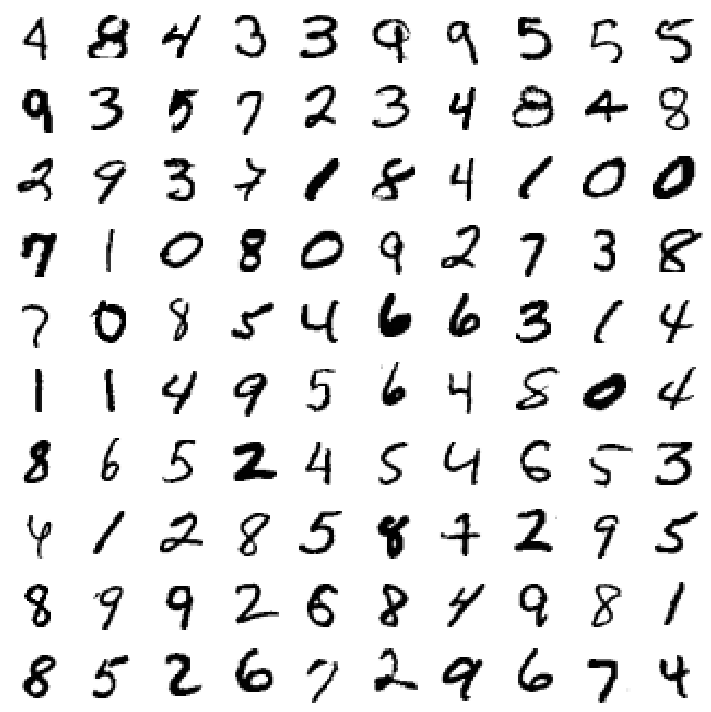

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Compile and train the network (note that this could take a while).

In [6]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 108s 2ms/step - loss: 0.2481 - accuracy: 0.9247 - val_loss: 0.0503 - val_accuracy: 0.9831
Epoch 2/12
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0881 - accuracy: 0.9735 - val_loss: 0.0367 - val_accuracy: 0.9872
Epoch 3/12
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.0351 - val_accuracy: 0.9884
Epoch 4/12
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0534 - accuracy: 0.9838 - val_loss: 0.0347 - val_accuracy: 0.9875
Epoch 5/12
60000/60000 [==============================] - 92s 2ms/step - loss: 0.0452 - accuracy: 0.9858 - val_loss: 0.0304 - val_accuracy: 0.9900
Epoch 6/12
60000/60000 [==============================] - 73s 1ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 0.0300 - val_accuracy: 0.9902
Epoch 7/12
60000/60000 [==============================] - 72s 1m

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.030149382841359595
Test accuracy: 0.9907000064849854


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


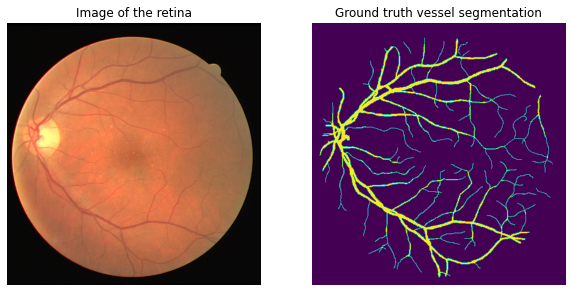

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
#import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'data/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


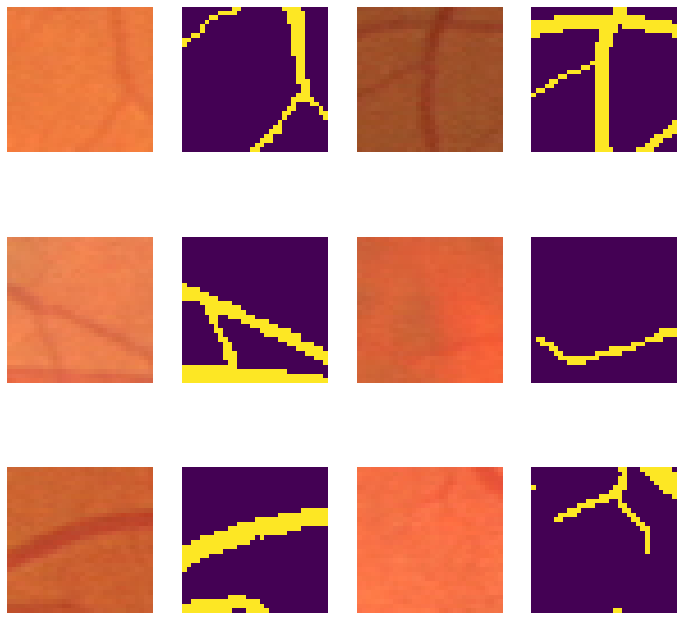

In [6]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [10]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 150 #250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

# save the model
# model.save('models/basic_unet.keras')

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/150
 - 72s - loss: 0.5203 - accuracy: 0.8264 - val_loss: 0.4985 - val_accuracy: 0.9202
Epoch 2/150
 - 63s - loss: 0.3290 - accuracy: 0.9477 - val_loss: 0.3535 - val_accuracy: 0.8429
Epoch 3/150
 - 55s - loss: 0.2248 - accuracy: 0.9546 - val_loss: 0.2898 - val_accuracy: 0.9211
Epoch 4/150
 - 54s - loss: 0.1990 - accuracy: 0.9564 - val_loss: 0.3002 - val_accuracy: 0.9159
Epoch 5/150
 - 55s - loss: 0.1822 - accuracy: 0.9541 - val_loss: 0.7733 - val_accuracy: 0.6918
Epoch 6/150
 - 55s - loss: 0.1518 - accuracy: 0.9581 - val_loss: 0.3279 - val_accuracy: 0.9211
Epoch 7/150
 - 55s - loss: 0.1441 - accuracy: 0.9584 - val_loss: 0.2904 - val_accuracy: 0.9257
Epoch 8/150
 - 54s - loss: 0.1456 - accuracy: 0.9590 - val_loss: 0.3034 - val_accuracy: 0.9245
Epoch 9/150
 - 56s - loss: 0.1607 - accuracy: 0.9529 - val_loss: 0.4241 - val_accuracy: 0.8265
Epoch 10/150
 - 54s - loss: 0.1480 - accuracy: 0.9558 - val_loss: 0.2113 - val_accuracy: 0.9459
Epoch 11/150
 -

### Visualizing the segmentation results

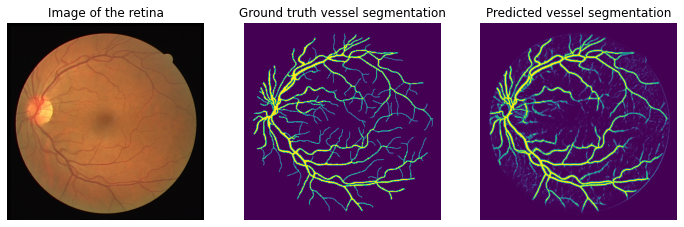

In [11]:
# run the model on one test image and show the results
from unet_utils import preprocessing
from keras.models import load_model

model = load_model('models/basic_unet.keras')

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>



## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 




In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# initialize fully convolutional model
model_FC = Sequential()

# build model architecture
model_FC.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_FC.add(Conv2D(64, (3, 3), activation='relu'))
model_FC.add(MaxPooling2D(pool_size=(2, 2)))
model_FC.add(Dropout(0.25))
model_FC.add(Conv2D(128, (12,12), activation='relu')) 
model_FC.add(Dropout(0.5))
model_FC.add(Conv2D(10, (1,1), activation='softmax'))
model_FC.add(Flatten())

model_FC.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 1, 1, 128)         1179776   
                                                                 
 dropout_9 (Dropout)         (None, 1, 1, 128)         0         
                                                      

In [15]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model_FC.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model_FC.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model_FC.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 40s 84ms/step - loss: 0.2533 - accuracy: 0.9227 - val_loss: 0.0542 - val_accuracy: 0.9816
Epoch 2/12
469/469 [==============================] - 46s 98ms/step - loss: 0.0915 - accuracy: 0.9731 - val_loss: 0.0413 - val_accuracy: 0.9870
Epoch 3/12
469/469 [==============================] - 105s 223ms/step - loss: 0.0693 - accuracy: 0.9785 - val_loss: 0.0396 - val_accuracy: 0.9871
Epoch 4/12
469/469 [==============================] - 69s 147ms/step - loss: 0.0586 - accuracy: 0.9822 - val_loss: 0.0358 - val_accuracy: 0.9885
Epoch 5/12
469/469 [==============================] - 41s 88ms/step - loss: 0.0488 - accuracy: 0.9846 - val_loss: 0.0368 - val_accuracy: 0.9879
Epoch 6/12
469/469 [==============================] - 41s 87ms/step - loss: 0.0416 - accuracy: 0.9872 - val_loss: 0.0296 - val_accuracy: 0.9909
Epoch 7/12
469/469 [==============================] - 41s 88ms/step - loss: 0.0399 - accuracy: 0.9879 - val_loss: 0.0291 - val_accura

After training the FCN (Fully Convolutional Network) and running it on the same test set as the regular CNN, we can see that we obtain the exact same test accuracy as the regular convolutional neural network earlier. This shows us that these networks represent the same model, but in a different way. The test loss for the FCN  is very similar to that of the regular CNN, it is even a tiny bit lower.

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>




The role of skip connections in U-net neural networks, is that it makes sure that information from earlier layers propagates well to deeper layers of the network. In deep neural networks, a loss of information can occur when information needs to be passed down from layer to layer, many times.

Additionally, it improves the performance of backpropagation. Since the values associated with backpropagation are often lower than 1, and values are multiplied many times over all the computations, the gradient will get smaller and smaller. We call this a vanishing gradient. At some point, the gradient might become so small that earlier layers are not getting updated, and we no longer observe a decrease in training loss, yet it is still much higher than we want. Adding skip connections allows the backpropagation algorithm to get to the earlier layers of the network in less steps, resulting in the gradient not decreasing as quickly.

It is possible to train the same architecture without the skip connections, since they are not vital for the network to perform, but the performance will be much worse. They are solely there to mitigate the vanishing gradient problem, and improve the training loss. If the skip connections are ommitted, the network will still train, but we will never achieve a training loss as low as when we would include them.

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

Answer:




Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 584, 565, 3)
(2, 584, 565, 1)


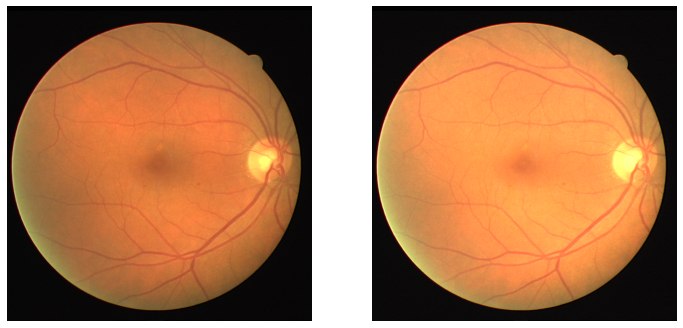

In [12]:
# Add random brightness augmentation to input of model

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('code/') 

from sklearn.model_selection import train_test_split
from unet_model import unet
from unet_utils import extract_patches, preprocessing, datagenerator, load_data
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import random_brightness
from glob import glob
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

# location of the DRIVE dataset
data_folder = 'data/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# pad the validation data to fit the U-Net model
val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

# print(X_train.shape)
# print(y_train.shape)

# create augmented image
X_train_hsv = rgb_to_hsv(X_train)                                                   # rgb to hsv, brightness value is more easily accessible
X_train_hsv[:, :, :, 2] = X_train_hsv[:, :, :, 2] * (0.5 + np.random.uniform())     # uniformly scale channel V
X_train_hsv[:, :, :, 2][X_train_hsv[:, :, :, 2] > 225] = 225                        # out of range values are reset
X_train_RB = np.array(hsv_to_rgb(X_train_hsv))                                      # hsv to rgb, so image is comparable with X_train image

# show original image and augmented image
plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(X_train[0])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(X_train_RB[0])

# add augmented image to training data - same image, but with different brightness
X_train = np.concatenate((X_train, X_train_RB), axis=0)
print(X_train.shape)

# also duplicate segmentation, no augmentation necessary for this
y_train = np.concatenate((y_train, y_train), axis=0)
print(y_train.shape)


In [13]:
# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 150 #250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

# save the model
# model.save('models/RB_aug_unet.keras')


Epoch 1/150
 - 75s - loss: 0.5265 - accuracy: 0.8056 - val_loss: 0.4168 - val_accuracy: 0.9211
Epoch 2/150
 - 56s - loss: 0.2921 - accuracy: 0.9525 - val_loss: 0.2953 - val_accuracy: 0.9211
Epoch 3/150
 - 59s - loss: 0.1931 - accuracy: 0.9611 - val_loss: 0.2776 - val_accuracy: 0.9211
Epoch 4/150
 - 56s - loss: 0.1585 - accuracy: 0.9635 - val_loss: 0.2744 - val_accuracy: 0.9211
Epoch 5/150
 - 54s - loss: 0.1371 - accuracy: 0.9630 - val_loss: 0.2726 - val_accuracy: 0.9212
Epoch 6/150
 - 55s - loss: 0.1229 - accuracy: 0.9632 - val_loss: 0.2978 - val_accuracy: 0.9208
Epoch 7/150
 - 52s - loss: 0.1171 - accuracy: 0.9651 - val_loss: 0.3303 - val_accuracy: 0.9208
Epoch 8/150
 - 53s - loss: 0.1004 - accuracy: 0.9672 - val_loss: 0.3492 - val_accuracy: 0.9210
Epoch 9/150
 - 53s - loss: 0.1029 - accuracy: 0.9647 - val_loss: 0.2499 - val_accuracy: 0.9288
Epoch 10/150
 - 53s - loss: 0.1012 - accuracy: 0.9655 - val_loss: 0.2300 - val_accuracy: 0.9217
Epoch 11/150
 - 56s - loss: 0.0973 - accuracy: 0.

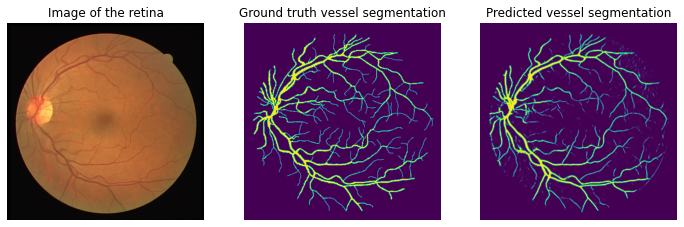

In [14]:
# run the model on one test image and show the results
from unet_utils import preprocessing
from keras.models import load_model

model = load_model('models/RB_aug_unet.keras')

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 584, 565, 3)
(2, 584, 565, 1)


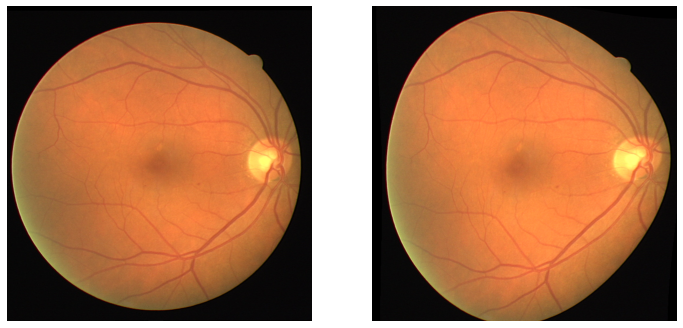

In [15]:
# Add random brightness AND B-spline geometric augmentation to input of model

import os
import sys
import numpy as np
import gryds
import matplotlib.pyplot as plt
sys.path.append('code/') 

from sklearn.model_selection import train_test_split
from unet_model import unet
from unet_utils import extract_patches, preprocessing, datagenerator, load_data
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import random_brightness
from glob import glob
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

# location of the DRIVE dataset
data_folder = 'data/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# pad the validation data to fit the U-Net model
val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

# first, adjust brightness of X_train image
X_train_hsv = rgb_to_hsv(X_train)                                                   # rgb to hsv, brightness value is more easily accessible
X_train_hsv[:, :, :, 2] = X_train_hsv[:, :, :, 2] * (0.5 + np.random.uniform())     # uniformly scale channel V
X_train_hsv[:, :, :, 2][X_train_hsv[:, :, :, 2] > 225] = 225                        # out of range values are reset
X_train_RB = np.array(hsv_to_rgb(X_train_hsv))                                      # hsv to rgb, so image is comparable with X_train image

# second, apply b-spline geometric augmentation to X_train_RB

# Define a random 3x3 B-spline grid for a 3D image:
random_grid = np.random.rand(2, 3, 3)    # Make a random 2D 3 x 3 grid
random_grid -= 0.5                       # Move the displacements to the -0.5 to 0.5 grid
random_grid /= 10                        # Scale the grid to -0.05 to 0.05 displacements

# Define a B-spline transformation object
bspline = gryds.BSplineTransformation(random_grid)

# Define an interpolator object for the image, 3x for all color channels of the image
X_train_Bspline = np.zeros(X_train_RB.shape)
for ch in range(X_train_RB.shape[3]):
    interpolator = gryds.Interpolator(X_train_RB[0, :, :, ch])          # Create interpolator object for channel
    X_train_Bspline[0, :, :, ch] = interpolator.transform(bspline)      # Transform the image using the B-spline transformation

# Also use B-spline transformation on segmentation
y_train_Bspline = np.zeros(y_train.shape)
interpolator = gryds.Interpolator(y_train[0, :, :, 0])
y_train_Bspline[0, :, :, 0] = interpolator.transform(bspline)

# show original image and augmented image
plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(X_train[0])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(X_train_Bspline[0])

# add augmented image to training data - same image, but with different brightness and B-spline transformation
X_train = np.concatenate((X_train, X_train_Bspline), axis=0)
print(X_train.shape)

# also duplicate segmentation, no augmentation necessary for this
y_train = np.concatenate((y_train, y_train_Bspline), axis=0)
print(y_train.shape)


In [16]:
# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 150 #250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

# save the model
model.save('models/RB_Bspline_aug_unet.keras')


Epoch 1/150
 - 62s - loss: 0.4742 - accuracy: 0.4633 - val_loss: 0.3641 - val_accuracy: 0.9211
Epoch 2/150
 - 61s - loss: 0.2583 - accuracy: 0.5289 - val_loss: 0.2809 - val_accuracy: 0.9211
Epoch 3/150
 - 62s - loss: 0.1793 - accuracy: 0.5287 - val_loss: 0.2929 - val_accuracy: 0.9206
Epoch 4/150
 - 61s - loss: 0.1564 - accuracy: 0.5170 - val_loss: 0.3223 - val_accuracy: 0.9206
Epoch 5/150
 - 61s - loss: 0.1280 - accuracy: 0.5122 - val_loss: 0.3290 - val_accuracy: 0.9199
Epoch 6/150
 - 63s - loss: 0.1190 - accuracy: 0.5056 - val_loss: 0.3794 - val_accuracy: 0.9209
Epoch 7/150
 - 61s - loss: 0.1473 - accuracy: 0.5249 - val_loss: 0.9378 - val_accuracy: 0.6039
Epoch 8/150
 - 61s - loss: 0.1155 - accuracy: 0.5305 - val_loss: 0.2724 - val_accuracy: 0.9290
Epoch 9/150
 - 63s - loss: 0.1049 - accuracy: 0.5390 - val_loss: 0.2335 - val_accuracy: 0.9364
Epoch 10/150
 - 60s - loss: 0.0984 - accuracy: 0.5385 - val_loss: 0.2700 - val_accuracy: 0.9349
Epoch 11/150
 - 61s - loss: 0.0959 - accuracy: 0.

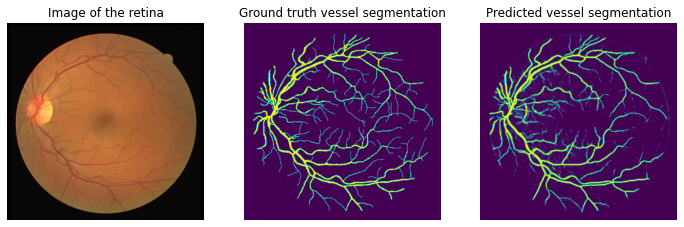

In [17]:
# run the model on one test image and show the results
from unet_utils import preprocessing
from keras.models import load_model

model = load_model('models/RB_Bspline_aug_unet.keras')

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

In [21]:
# Compare the performance of the three models

models = ['basic_unet', 'RB_aug_unet', 'RB_Bspline_aug_unet']

for m in range(len(models)):
    # load model
    model = load_model(f'models/{models[m]}.keras')

    # test data paths
    impaths_test = glob(data_folder + 'test/images/*.tif')

    # load data
    test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

    # pad the data to fit the U-Net model
    test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                                desired_shape=(584, 584))

    # use a single image to evaluate
    X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

    # predict test samples
    test_prediction = model.predict(X_test, batch_size=4)

    # threshold predictions, so more comparable for dice score
    test_prediction[test_prediction > 0.1] = 1
    test_prediction[test_prediction <= 0.1] = 0

    # compute dice score
    A = test_prediction[0]
    B = test_segmentations[0]
    dice = 2*np.sum(A*B) / (np.sum(A)+np.sum(B))

    # print dice score
    print(f"The dice score for the {models[m]} model is: {dice}")
    

The dice score for the basic_unet model is: 0.6594174386856005
The dice score for the RB_aug_unet model is: 0.7680984878897363
The dice score for the RB_Bspline_aug_unet model is: 0.7259213378755033
